# ボールと選手のデータセット分析

このノートブックは、テニスの試合におけるボールと選手両方のアノテーションを含むデータセットを分析します。データはCOCOフォーマットで、以下の特定の規約に従っています。

* **ボール**: 単一のキーポイント `(x, y, v)` と固定サイズのバウンディングボックス（面積=64）でアノテーションされます。
* **選手**: バウンディングボックスと一連のポーズキーポイントでアノテーションされます。

## 1. セットアップ

ライブラリをインポートし、アノテーションファイルを読み込みます。

In [2]:
import json
import random
from pathlib import Path

# cv2の代わりにPillowとmatplotlib.patchesを使用
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns

# プロットスタイルの設定
sns.set_style("whitegrid")

In [3]:
# --- パス設定 ---
DATA_DIR = Path("/app/data/processed/ball")
ANNOTATION_FILE = DATA_DIR / "annotation.json"
IMAGE_DIR = DATA_DIR / "images"

# --- アノテーションの読み込み ---
with open(ANNOTATION_FILE, "r") as f:
    coco_data = json.load(f)

# --- データフレームの作成 ---
images_df = pd.DataFrame(coco_data["images"])
annotations_df = pd.DataFrame(coco_data["annotations"])
categories_df = pd.DataFrame(coco_data["categories"])

print("データは正常に読み込まれました。")

データは正常に読み込まれました。


## 2\. データセット概要

データセットの内容の全体像を把握します。

In [4]:
# --- 基本統計 ---
num_images = len(images_df)
num_annotations = len(annotations_df)
num_categories = len(categories_df)

print(f"画像数: {num_images}")
print(f"アノテーション数: {num_annotations}")

# --- カテゴリ詳細 ---
print("\n--- カテゴリ ---")
print(categories_df.to_string())

# --- カテゴリごとにアノテーションを分割 ---
# カテゴリ名とIDを取得
cat_name_to_id = {cat['name']: cat['id'] for cat in coco_data['categories']}
ball_cat_id = cat_name_to_id.get("ball")
player_cat_id = cat_name_to_id.get("player")

ball_anns = annotations_df[annotations_df['category_id'] == ball_cat_id]
player_anns = annotations_df[annotations_df['category_id'] == player_cat_id]

print(f"\nボールのアノテーション数: {len(ball_anns)}")
print(f"選手のアノテーション数: {len(player_anns)}")

画像数: 19106
アノテーション数: 56965

--- カテゴリ ---
   id    name supercategory                                                                                                                                                                                               keypoints                                                                                                                                                               skeleton
0   1    ball        sports                                                                                                                                                                                                [center]                                                                                                                                                                     []
1   2  player        person  [nose, left_eye, right_eye, left_ear, right_ear, left_shoulder, right_shoulder, left_elbow, right_elbow, left_wrist, right_wrist, left_hip, 

## 3\. ボールのアノテーション分析

「ボール」カテゴリのアノテーションを専門的に分析します。

### 3.1. キーポイントの可視性

ボールのキーポイントの可視性ステータスを確認します。

/tmp/ipykernel_69/1803310261.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball_anns['visibility'] = ball_anns['keypoints'].apply(get_visibility)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12463 (\N{KATAKANA LETTER KU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12523 (\N{KATAKANA LETTER RU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/

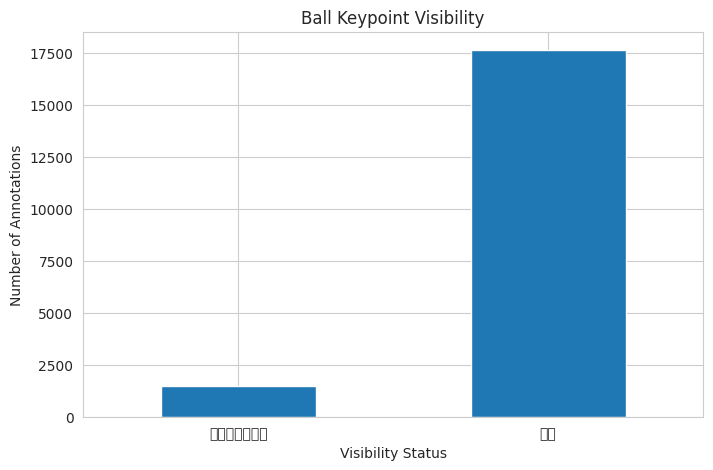

In [5]:
# keypointsリスト [x, y, v] から可視性(v)を抽出する関数
def get_visibility(keypoints):
    if not keypoints:
        return 0
    return keypoints[2]

ball_anns['visibility'] = ball_anns['keypoints'].apply(get_visibility)

visibility_counts = ball_anns['visibility'].value_counts().sort_index()
# インデックスを日本語にマッピング
visibility_counts.index = visibility_counts.index.map({0: 'ラベルなし', 1: 'オクルージョン', 2: '表示'})

plt.figure(figsize=(8, 5))
visibility_counts.plot(kind='bar', rot=0)
plt.title('Ball Keypoint Visibility')
plt.xlabel('Visibility Status')
plt.ylabel('Number of Annotations')
plt.show()

### 3.2. バウンディングボックスの面積

ボールのバウンディングボックスの面積が64で固定されていることを確認します。

/tmp/ipykernel_69/545996571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ball_anns['area'] = ball_anns['bbox'].apply(lambda x: x[2] * x[3])


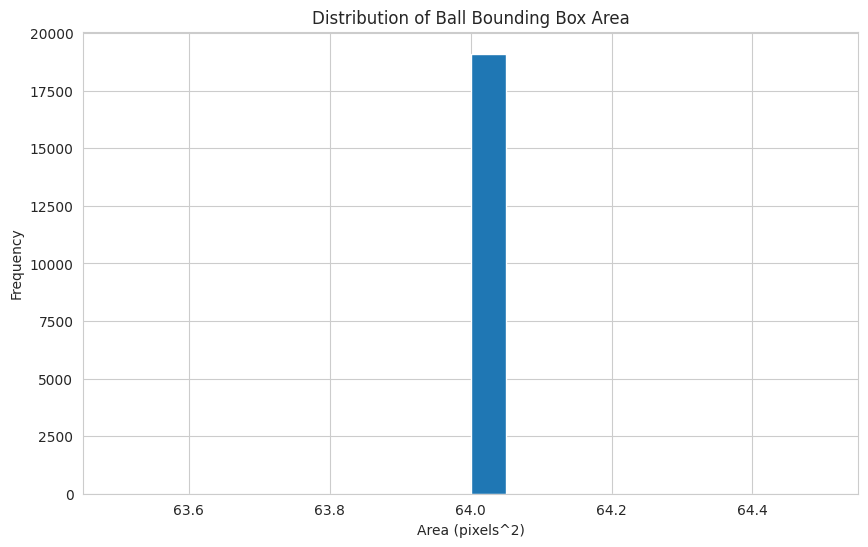

ボールのバウンディングボックス面積のユニークな値: [64]


In [6]:
ball_anns['area'] = ball_anns['bbox'].apply(lambda x: x[2] * x[3])

plt.figure(figsize=(10, 6))
plt.hist(ball_anns['area'], bins=20)
plt.title('Distribution of Ball Bounding Box Area')
plt.xlabel('Area (pixels^2)')
plt.ylabel('Frequency')
plt.show()

print(f"ボールのバウンディングボックス面積のユニークな値: {ball_anns['area'].unique()}")

## 4\. 選手のアノテーション分析

次に、「選手」のアノテーションを分析します。

### 4.1. バウンディングボックスの面積

/tmp/ipykernel_69/2019000058.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_anns['area'] = player_anns['bbox'].apply(lambda x: x[2] * x[3])


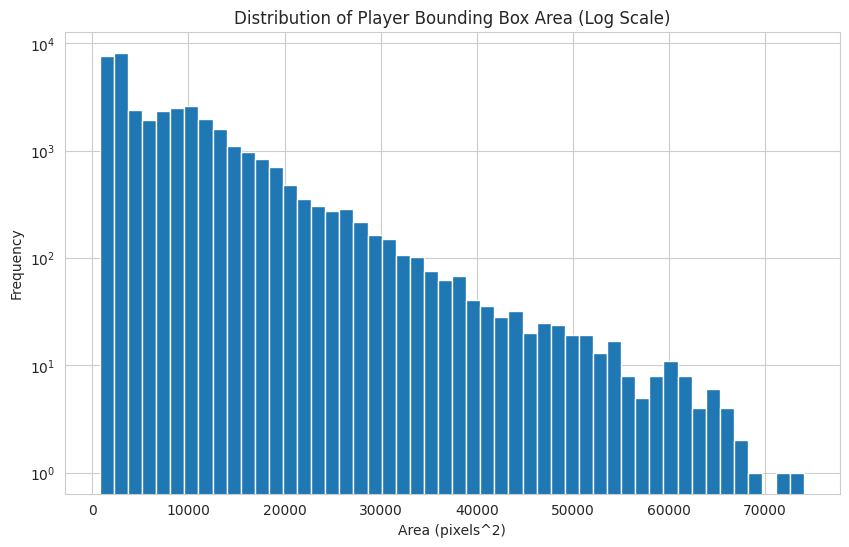

In [7]:
player_anns['area'] = player_anns['bbox'].apply(lambda x: x[2] * x[3])

plt.figure(figsize=(10, 6))
plt.hist(player_anns['area'], bins=50, log=True)
plt.title('Distribution of Player Bounding Box Area (Log Scale)')
plt.xlabel('Area (pixels^2)')
plt.ylabel('Frequency')
plt.show()

### 4.2. キーポイントの数

各選手に対して通常いくつのポーズキーポイントがアノテーションされているかを分析します。

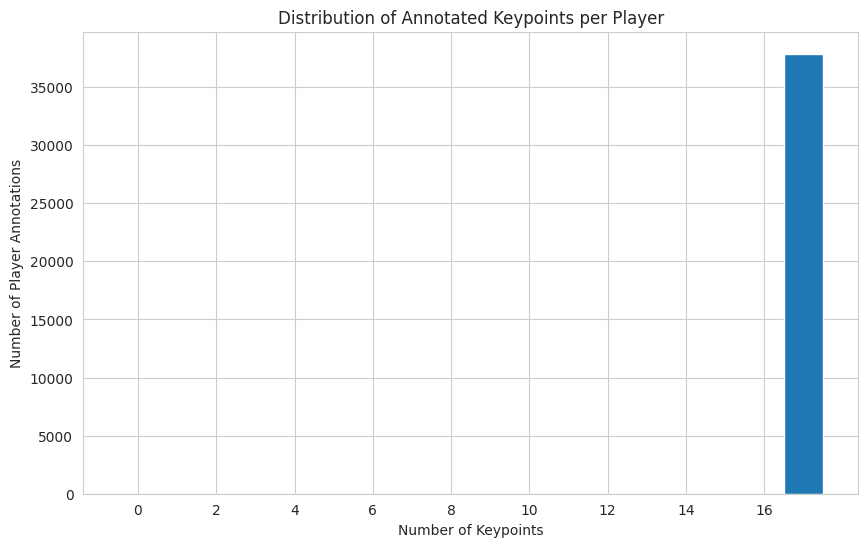

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(player_anns['num_keypoints'], bins=range(0, player_anns['num_keypoints'].max() + 2), align='left')
plt.title('Distribution of Annotated Keypoints per Player')
plt.xlabel('Number of Keypoints')
plt.ylabel('Number of Player Annotations')
plt.xticks(range(0, player_anns['num_keypoints'].max() + 1, 2))
plt.grid(True)
plt.show()

## 5\. 統合分析

### 5.1. 画像ごとのアノテーション数

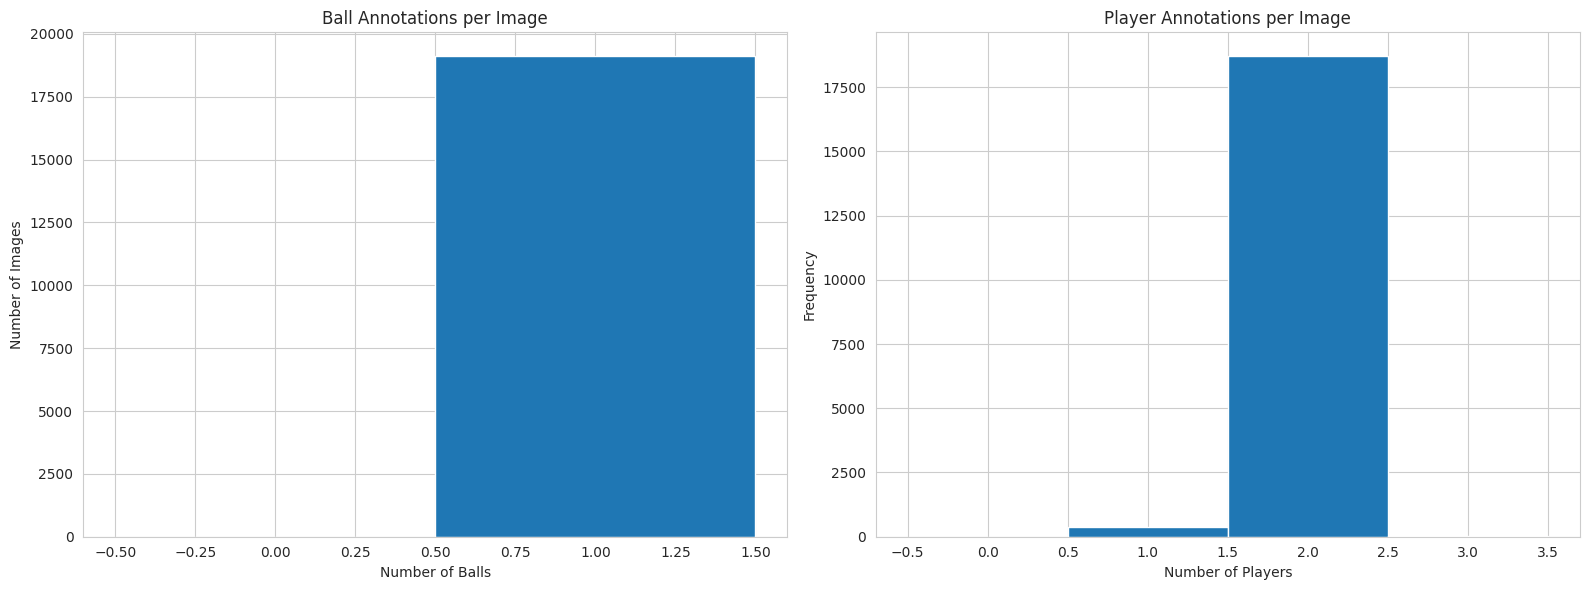

In [9]:
ann_per_image = annotations_df.groupby('image_id')['category_id'].value_counts().unstack(fill_value=0)
ann_per_image.columns = [coco_data['categories'][cat_id-1]['name'] for cat_id in ann_per_image.columns]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ann_per_image['ball'].plot(kind='hist', ax=axes[0], bins=range(ann_per_image['ball'].max() + 2), align='left')
axes[0].set_title('Ball Annotations per Image')
axes[0].set_xlabel("Number of Balls")
axes[0].set_ylabel("Number of Images")

ann_per_image['player'].plot(kind='hist', ax=axes[1], bins=range(ann_per_image['player'].max() + 2), align='left')
axes[1].set_title('Player Annotations per Image')
axes[1].set_xlabel("Number of Players")

plt.tight_layout()
plt.show()

## 6\. 可視化

最後に、ランダムなサンプル画像をすべてのアノテーションとともに可視化します。

AttributeError: module 'matplotlib.pyplot' has no attribute 'lines'

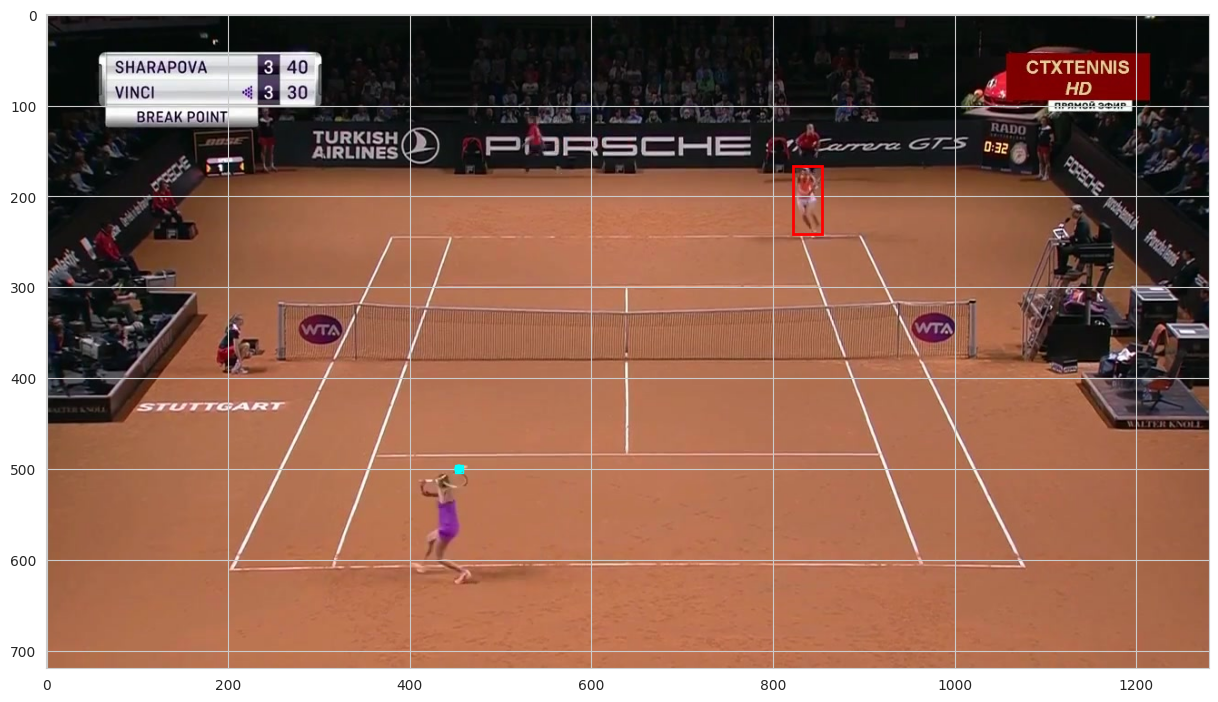

In [ ]:
def get_category_info(category_id, categories):
    # カテゴリIDに対応するカテゴリ情報を取得
    for cat in categories:
        if cat['id'] == category_id:
            return cat
    return None

def draw_annotations_on_ax(ax, image_id, images_df, annotations_df, categories, image_dir):
    # cv2の代わりにPillowとMatplotlibを使用してアノテーションを描画する関数
    
    # 画像情報を取得し、Pillowで画像を開く
    image_info = images_df[images_df["id"] == image_id].iloc[0]
    image_path = image_dir / image_info["original_path"]
    image = Image.open(image_path).convert("RGB")
    
    # Matplotlibのaxesに画像を表示
    ax.imshow(image)

    # 対象画像の全アノテーションを取得
    img_annotations = annotations_df[annotations_df["image_id"] == image_id]

    for _, ann in img_annotations.iterrows():
        cat_info = get_category_info(ann['category_id'], categories)
        cat_name = cat_info['name']
        
        if cat_name == 'ball':
            # キーポイントを円として、バウンディングボックスを矩形として描画
            x, y, v = ann['keypoints']
            if v > 0: # 可視性がある場合のみ描画
                # 円 (キーポイント)
                circle = patches.Circle((x, y), 5, facecolor=(0, 1, 1), edgecolor='none') # Cyan
                ax.add_patch(circle)
            
            bx, by, bw, bh = [int(c) for c in ann['bbox']]
            # 矩形 (バウンディングボックス)
            rect = patches.Rectangle((bx, by), bw, bh, linewidth=1, edgecolor=(0, 1, 1), facecolor='none') # Cyan
            ax.add_patch(rect)

        elif cat_name == 'player':
            # バウンディングボックスを描画
            bx, by, bw, bh = [int(c) for c in ann['bbox']]
            rect = patches.Rectangle((bx, by), bw, bh, linewidth=2, edgecolor=(1, 0, 0), facecolor='none') # Red
            ax.add_patch(rect)

            # ポーズキーポイントとスケルトンを描画
            kpts = np.array(ann['keypoints']).reshape(-1, 3)
            skeleton = cat_info.get('skeleton', [])
            for start_idx, end_idx in skeleton:
                # スケルトンは1-based indexなので-1する
                x1, y1, v1 = kpts[start_idx-1]
                x2, y2, v2 = kpts[end_idx-1]
                if v1 > 0 and v2 > 0: # 両方のキーポイントが可視の場合のみ線を描画
                    ax.plot([x1, x2], [y1, y2], color=(0, 1, 0), linewidth=2) # Green
# --- ランダムなサンプルを表示 ---
random_image_id = random.choice(images_df["id"])

# MatplotlibのFigureとAxesを作成
fig, ax = plt.subplots(figsize=(15, 10))

# 新しい描画関数を呼び出す
draw_annotations_on_ax(ax, random_image_id, images_df, annotations_df, coco_data['categories'], IMAGE_DIR)

ax.set_title(f"Sample Image with Annotations (Image ID: {random_image_id})")
ax.axis("off") # 軸を非表示にする
plt.show()